# POSEIDON: Pose Estimation & Activity Recognition using GNNs

Team Members (Group 16): 
1. Chong Jun Rong Brian (A0290882U)
2. Parashara Ramesh (A0285647M)
3. Ng Wei Jie Brandon (A0184893L)

In [1]:
%load_ext autoreload
%autoreload 2

<h2><u> Table of contents </u></h2>

1. What is this project about?
<br> 1.1. Project Motivation
<br> 1.2. Project Description
<br> 1.3. Project Setup 
<br> 1.4. Project Changes from Initial Proposal
<br> 1.5. Project Presentation Video

2. Model building approach 

3. Human 3.6M Dataset
<br> 3.1. Summary of the dataset
<br> 3.2. Preparing the dataset
<br> 3.3. Visualizing poses
<br> 3.4. Training baseline model (SimplePose)
<br> 3.5. Training Graph Convolutional model (SimplePoseGNN)
<br> 3.6. Training Graph Transformer model (SimplePoseGAT)
<br> 3.7. Training Toplogy Adaptive Graph Convolutional model (SimplePoseTAG)

4. Custom Dataset
<br> 4.1. Summary of the dataset
<br> 4.2. Training baseline model (SimplePose)
<br> 4.3. Training Graph Convolutional model (SimplePoseGNN)
<br> 4.4. Training Graph Transformer model (SimplePoseGAT)
<br> 4.5. Training Toplogy Adaptive Graph Convolutional model (SimplePoseTAG)

5. Evaluation
<br> 5.1 Human 3.6M dataset
<br> 5.2 Custom Dataset

6. Lessons Learnt & Conclusions
7. Resources


<h2><u>1. What is this project about?</u></h2>
<h3><u>1.1 Project Motivation</u></h3>

Accurately predicting 3D human poses from 2D keypoints is essential for applications like motion capture and activity recognition. Traditional methods, such as direct regression or lifting techniques, often fail to capture the intricate spatial relationships between body joints. By modeling 2D pose keypoints as graphs, we can utilize the inherent connectivity between joints to enhance 3D pose estimation. Furthermore, recognizing and classifying human activities from these poses is vital in areas like surveillance and healthcare. This project aims to investigate how Graph Neural Networks (GNNs) can improve both 3D pose estimation and activity recognition.

<h3><u>1.2 Project Description</h3></u>

This project has two primary objectives.

The first is to accurately predict 3D human poses from 2D keypoints using Graph Neural Networks (GNNs).

* We will begin by developing two baseline models: one utilizing a standard Neural Network (NN) and Convolutional Neural Network (CNN), and the other employing a simple GNN for 3D pose estimation.
* Next, we will reimplement the SemGCN model, which represents 2D pose keypoints as graph nodes with edges capturing the connectivity between joints.
* Finally, we aim to enhance the SemGCN model by exploring alternative GNN architectures and introducing modifications to improve its performance.

The second objective is to classify human activities based on 2D keypoints. For this task, we will use custom datasets to evaluate the generalization capabilities of GNN-based models for activity recognition.

<h3><u>1.3 Project Setup</u></h3>

1. Install the dependencies from `requirements.txt` using the command

`pip install -r requirements.txt`


<h2><u>2. Model Building Approach</u></h2>

The following sections attempts to build different ML models using the dataset which was just constructed above.

At a very high level these are the models we aim to build:
* SimplePose - A simple baseline ML model using classic DL layers
* SimplePoseGNN - A simple baseline GNN model using DGL and GNN layers
* SemGCN - A reimplementation of the [SemGCN paper](https://arxiv.org/abs/1904.03345) in DGL
* PoseGCN - A more complex GNN model by leveraging the insights gained from building the other GNN models.

<h2><u>3. Human 3.6M Dataset</u></h2>

<h3><u>3.1. Summary of the dataset </u></h3>

The [Human 3.6M dataset](http://vision.imar.ro/human3.6m/description.php) is a comprehensive dataset comprising 3.6 million 3D human poses, captured from 11 professional actors performing 17 everyday activities (e.g., talking, smoking, discussing).

This dataset utilizes a 3D motion capture system with 10 cameras to track reflective markers placed on the body, enabling automatic labeling of joint positions.

Participants were provided with detailed task instructions and visual examples of the actions to perform, but they were also allowed some freedom to move naturally during execution.

As a result, the Human 3.6M dataset serves as a valuable resource for 3D human pose estimation, action recognition, and other computer vision research tasks.

<h3><u>3.2. Dataset preparation </u></h3>

Downloading the Human 3.6M dataset directly from the official website requires a login. To simplify access, we will use a preprocessed version of the dataset, which is available on Google Drive [here](https://drive.google.com/file/d/1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s/view?usp=drive_link).

The preprocessing was originally performed by [Martinez et al](https://github.com/una-dinosauria/3d-pose-baseline) and is sourced from their repository.

The following cells outline the steps to download this preprocessed dataset and create train-test files after applying necessary transformations.

From Section 3 (Models) onward, we will use the preprocessed train-test files directly. Therefore, executing the cells in this section is optional.

#### Downloading the zip from google drive

In [2]:
# Download the zip from google drive
import gdown
import os

# file id from gdrive (refer to markdown cell above for full link)
file_id = '1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s' 
download_url = f'https://drive.google.com/uc?id={file_id}'

# Folder where you want to save the file
folder_path = os.path.join(os.getcwd(),"datasets", "h36m", "Original")
zip_file_path = os.path.join(folder_path, 'h36m.zip')

# Ensure the folder exists
os.makedirs(folder_path, exist_ok=True)

# Download the ZIP file
gdown.download(download_url, zip_file_path, quiet=False)

print(f"Downloaded ZIP file and saved to {zip_file_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s
From (redirected): https://drive.google.com/uc?id=1JGt3j9q5A8WzUY-QKfyMVJUUvfreri-s&confirm=t&uuid=49a2079e-120b-42b7-8bc4-5a0485772c20
To: /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original/h36m.zip
100%|██████████| 260M/260M [00:20<00:00, 12.5MB/s] 

Downloaded ZIP file and saved to /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original/h36m.zip


#### Extracting the contents into the same folder

In [3]:
# extracting the contents inside the /datasets/h36m/Original folder
import zipfile

print(f"Extracting files to {folder_path}..")
# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

print(f"Finished extracting files to {folder_path}")



Extracting files to /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original..
Finished extracting files to /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original


#### Saving the 3d positions into a compressed np file

In [4]:
import h5py
from glob import glob
from tqdm import tqdm
import numpy as np

output_filename = os.path.join(folder_path, 'data_3d_h36m')
subjects = ['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']

output = dict()
for subject in tqdm(subjects, desc= f'Processing subjects..'):
    output[subject] = dict()
    file_list = glob(os.path.join(folder_path, 'h36m', subject, 'MyPoses', '3D_positions', '*.h5'))
    assert len(file_list) == 30, "Expected 30 files for subject " + subject + ", got " + str(len(file_list))
    for f in file_list:
        action = os.path.splitext(os.path.basename(f))[0]

        if subject == 'S11' and action == 'Directions':
            continue  # Discard corrupted video

        with h5py.File(f) as hf:
            positions = hf.get('3D_positions')[:].reshape(32, 3, -1).transpose(2, 0, 1)
            positions /= 1000  # Meters instead of millimeters
            output[subject][action] = positions.astype('float32')

print(f'Saving compressed 3d positions into {output_filename}')
np.savez_compressed(output_filename, positions_3d=output)
print(f'Finished saving 3d positions into {output_filename}')
del output


Processing subjects..: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]


Saving compressed 3d positions into /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original/data_3d_h36m
Finished saving 3d positions into /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original/data_3d_h36m


#### Compute the ground truth 2d poses.

The motion capture system records 3D poses using 10 cameras in the world coordinate frame. By applying the intrinsic and extrinsic matrices of each camera, these 3D poses are projected into 2D poses as they would appear in the respective camera's frame. The coordinates are then normalized so that the x, y, and z values range between -1 and 1.

In [5]:
from data.camera import world_to_camera, project_to_2d, image_coordinates, wrap
from data.h36m_dataset import Human36mDataset

print('Computing ground-truth 2D poses...')
output_filename_2d = os.path.join(folder_path, 'data_2d_h36m_gt')

dataset = Human36mDataset(output_filename + '.npz')
output_2d_poses = {}
for subject in dataset.subjects():
    output_2d_poses[subject] = {}
    for action in dataset[subject].keys():
        anim = dataset[subject][action]

        positions_2d = []
        for cam in anim['cameras']:
            pos_3d = world_to_camera(anim['positions'], R=cam['orientation'], t=cam['translation'])
            pos_2d = wrap(project_to_2d, True, pos_3d, cam['intrinsic'])
            pos_2d_pixel_space = image_coordinates(pos_2d, w=cam['res_w'], h=cam['res_h'])
            positions_2d.append(pos_2d_pixel_space.astype('float32'))
        output_2d_poses[subject][action] = positions_2d

print(f'Saving compressed 2d positions into {output_filename_2d}')
metadata = {
    'num_joints': dataset.skeleton().num_joints(),
    'keypoints_symmetry': [dataset.skeleton().joints_left(), dataset.skeleton().joints_right()]
}
np.savez_compressed(output_filename_2d, positions_2d=output_2d_poses, metadata=metadata)

print(f'Done saving compressed 2d positions into {output_filename_2d}')
del output_2d_poses

Computing ground-truth 2D poses...
Saving compressed 2d positions into /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original/data_2d_h36m_gt
Done saving compressed 2d positions into /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Original/data_2d_h36m_gt


#### Cleanup the extracted files and the downloaded zip

In [6]:
from shutil import rmtree

rmtree(os.path.join(folder_path, 'h36m'))
os.remove(os.path.join(folder_path, 'h36m.zip'))

#### Creating and saving train and test files from the saved npz files

In [7]:
from utils.data_utils import read_3d_data, create_2d_data, create_train_test_files
from data.h36m_dataset import TRAIN_SUBJECTS, TEST_SUBJECTS, Human36mDataset
import os

subjects_train = TRAIN_SUBJECTS
subjects_test = TEST_SUBJECTS

processed_dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Processed")
os.makedirs(processed_dataset_path, exist_ok=True)

dataset_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_3d_h36m.npz")
dataset = Human36mDataset(dataset_path)


#### Normalizing the 2D poses to [-1, 1] while preserving aspect ratio and 3D poses to camera's frame

In [8]:
print("Reading 3d npz file")
dataset = read_3d_data(dataset)

print("Reading 2d npz file")
dataset_2d_path = os.path.join(os.getcwd(), "datasets", "h36m", "Original", "data_2d_h36m_gt.npz")
keypoints = create_2d_data(dataset_2d_path, dataset)
print("Done")

Reading 3d npz file
Reading 2d npz file
Done


#### Select subset of distinct actions to train and test models

In [9]:
keep_actions = [
    'Greeting',
    'Photo',
    'Sitting',
    'SittingDown',
    'Walking'
]

#### Save the 2D poses, 3D poses, and actions in numpy files

In [10]:
print("Creating train datasets and saving into file")
_, _, _ = create_train_test_files(subjects_train, dataset, keypoints, "train", processed_dataset_path, keep_actions)

print("Creating test datasets and saving into file")
_, _, _ = create_train_test_files(subjects_test, dataset, keypoints, "test", processed_dataset_path, keep_actions)
print("Done")

Creating train datasets and saving into file
Saved pose actions in file /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Processed/train_actions.npy
Saved 3d poses in file /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Processed/train_3d_poses.npy
Saved 2d poses in file /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Processed/train_2d_poses.npy
Creating test datasets and saving into file
Saved pose actions in file /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Processed/test_actions.npy
Saved 3d poses in file /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Processed/test_3d_poses.npy
Saved 2d poses in file /home/nwjbrandon/NUS/Poseidon/datasets/h36m/Processed/test_2d_poses.npy
Done


<h3><u>3.3 Visualizing poses </u></h3>

Since the train and test files have already been saved, we will use these files for the remainder of the notebook.

These files are also available in this [Google Drive Link](https://drive.google.com/drive/folders/1d38hWSM8clZlI11nqljxBECog1KY-iTd?usp=sharing), which can be placed in the local path to skip the execution of earlier cells.

The visualizations below indicate that, after the processing steps outlined above, human poses are represented as skeletons consisting of 13 joints.

Let's visualise the poses for the 5 actions in the h3.6m dataset

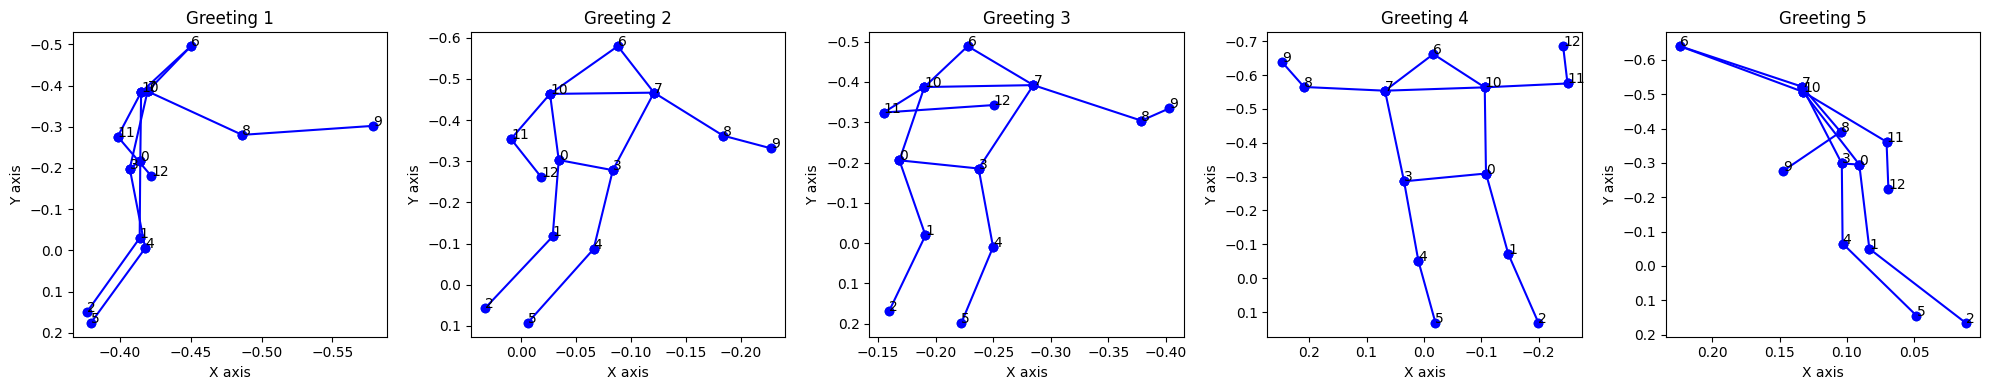

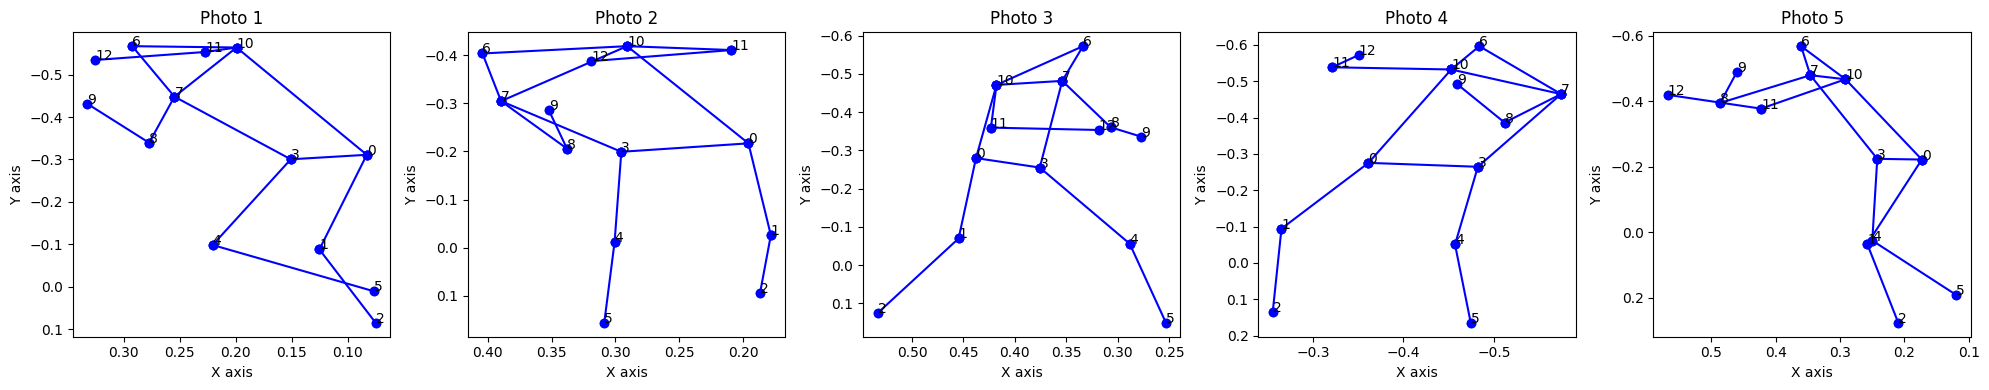

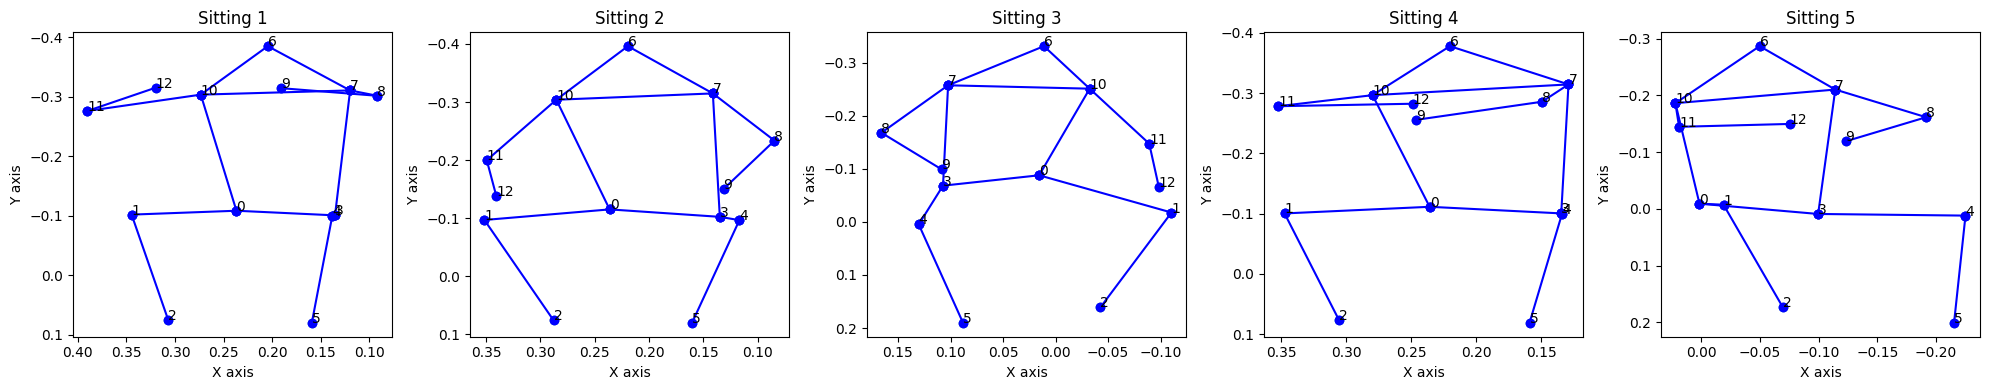

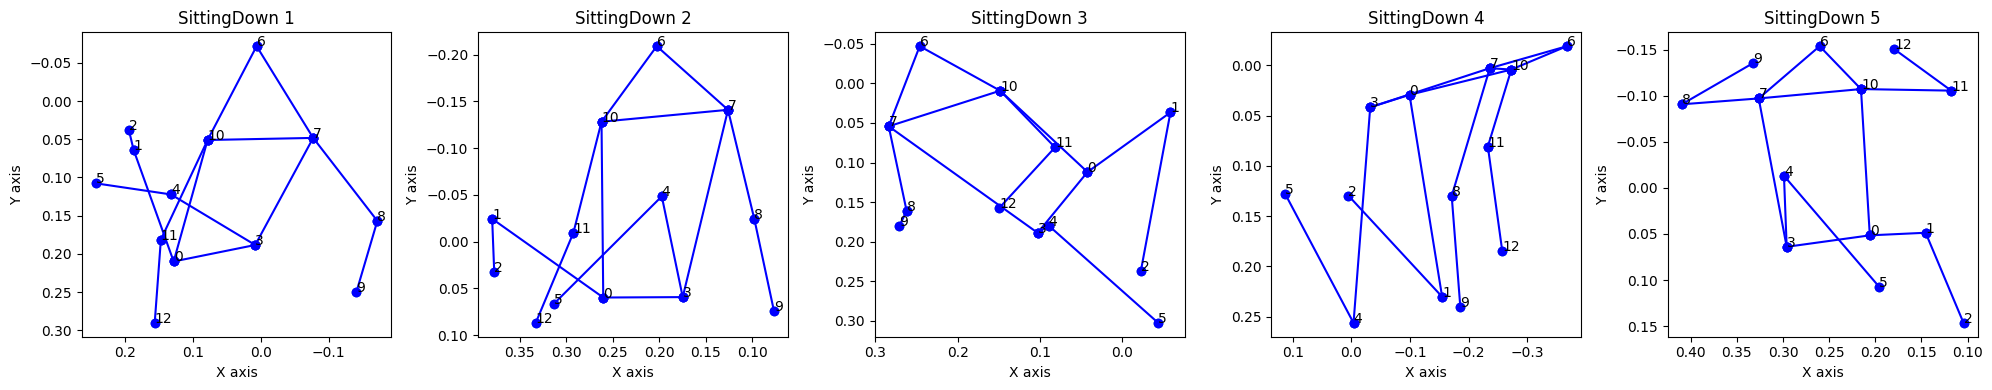

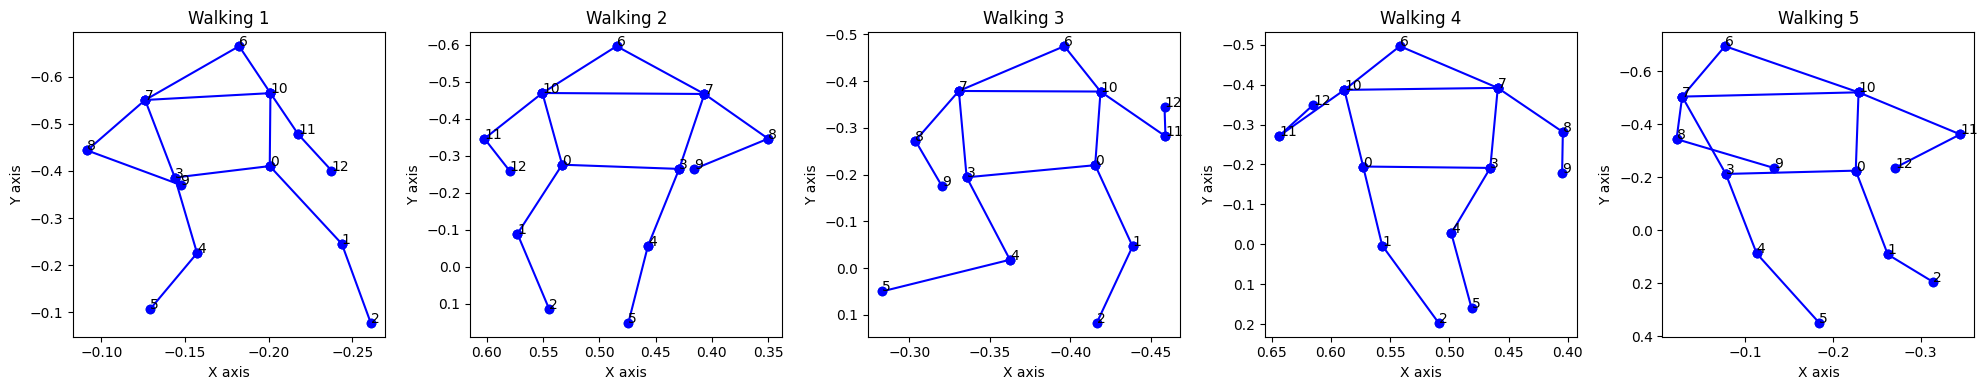

In [11]:
from utils.visualization_utils import visualize_2d_pose_actions

out_poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
out_actions = np.load("datasets/h36m/Processed/test_actions.npy")
for action in np.unique(out_actions):
    out_poses_2d_action = out_poses_2d[out_actions == action]
    visualize_2d_pose_actions(out_poses_2d_action, action=action)

Let's visualise the first 2D pose and corresponding 3D poses in the h3.6m dataset

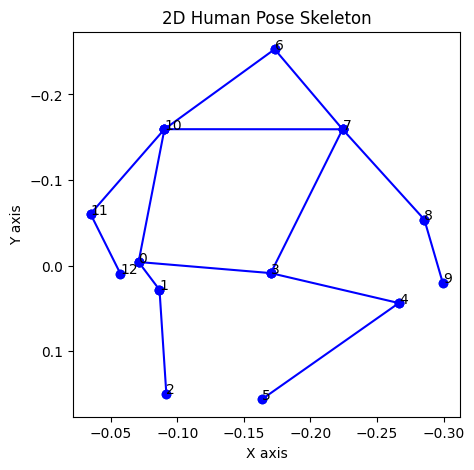

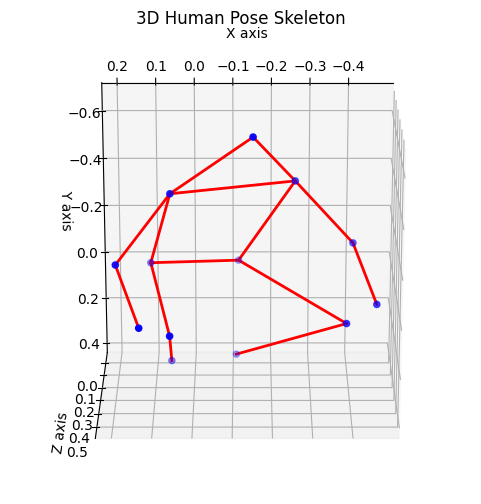

In [12]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose, visualize_3d_pose

poses_2d = np.load("datasets/h36m/Processed/test_2d_poses.npy")
poses_3d = np.load("datasets/h36m/Processed/test_3d_poses.npy")

visualize_2d_pose(poses_2d[0])
visualize_3d_pose(poses_3d[0], elev=110, azim=90)

Let's visualise the distribution of the 5 actions in the h3.6m train and test datasets

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def show_action_stats(actions, type):
    train_actions_df = pd.DataFrame(actions, columns=['actions'])
    action_counts = train_actions_df['actions'].value_counts()
    print(action_counts)
    
    action_counts.plot(kind='bar')
    
    # Step 4: Show the plot
    plt.title(f'{type} Action Distribution')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.show()


actions
SittingDown    58356
Walking        48656
Photo          35552
Sitting        32976
Greeting       22312
Name: count, dtype: int64


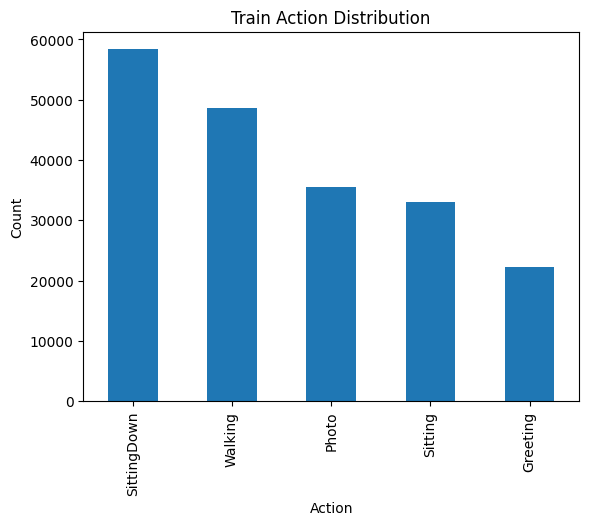

In [14]:
train_actions = np.load("datasets/h36m/Processed/train_actions.npy")
show_action_stats(train_actions, "Train")

actions
Sitting        18964
SittingDown    17492
Photo          15744
Greeting       11420
Walking        11332
Name: count, dtype: int64


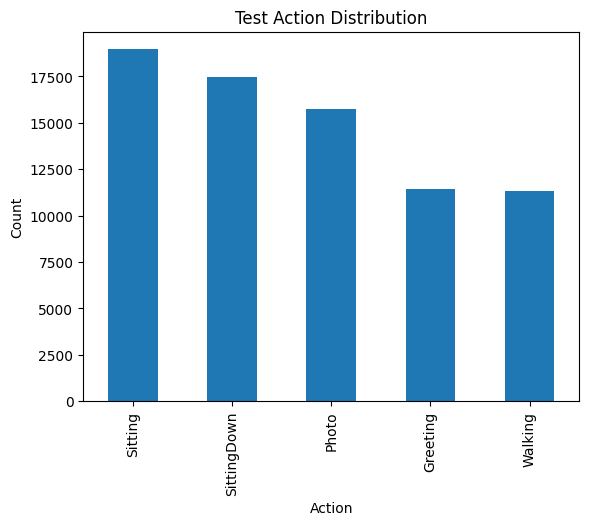

In [15]:
test_actions = np.load("datasets/h36m/Processed/test_actions.npy")
show_action_stats(test_actions, "Test")

Graph(num_nodes=13, num_edges=28,
      ndata_schemes={'feat_2d': Scheme(shape=(2,), dtype=torch.float32), 'label': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={'feat': Scheme(shape=(4,), dtype=torch.float32)})


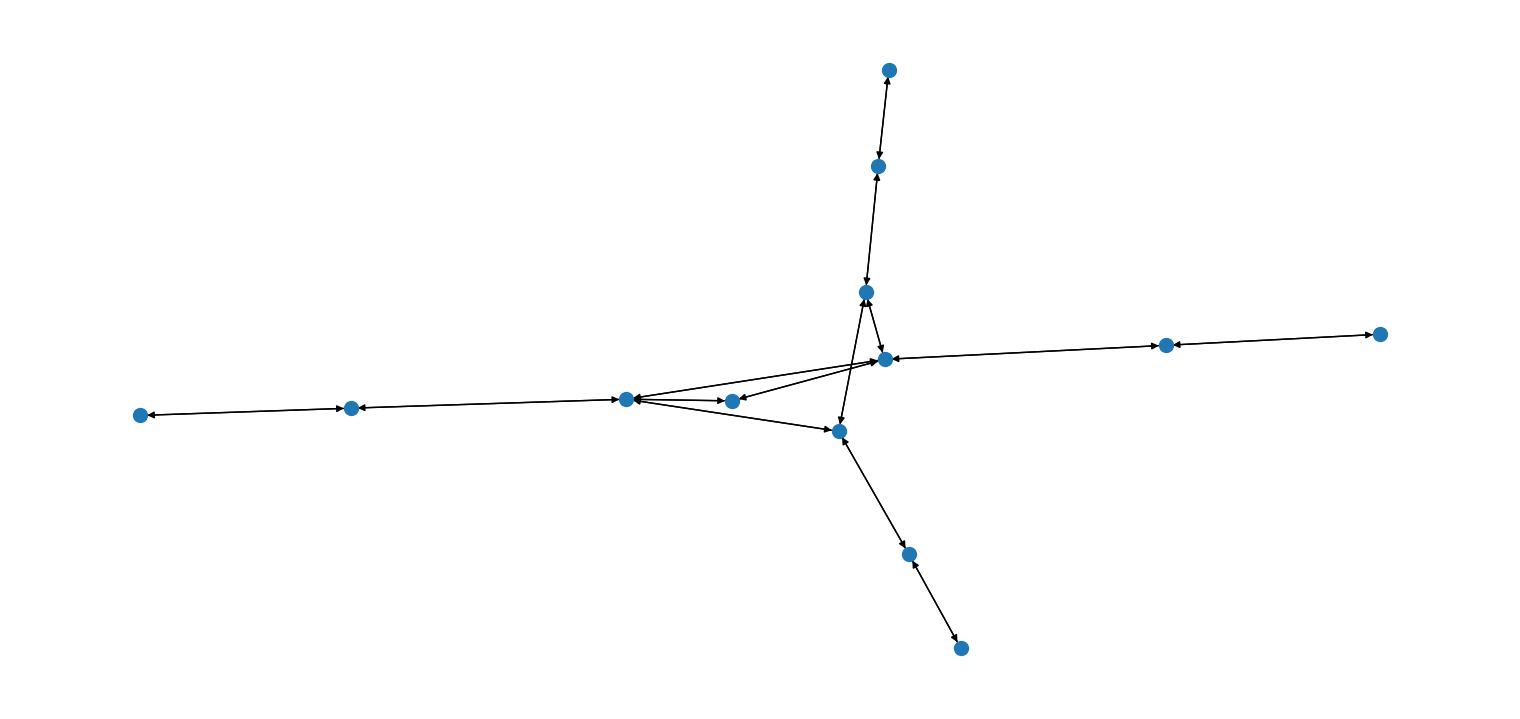

In [16]:
from dataloader.h36m_graph_loader_with_edge_feats import Human36MGraphEdgeDataset
import networkx as nx
import dgl

item = {
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
}

training_data = Human36MGraphEdgeDataset(item['training_2d_data_path'], item['training_3d_data_path'], item['training_label_path'])
g = training_data[0][0]
print(g)
options = {
    'node_size': 100,
    'width': 1,
}
G = dgl.to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)


<h2><u>4. Custom Dataset</u></h2>


<h3><u>4.1. Summary of the dataset </u></h3>

Alongside the Human 3.6M dataset, we created a custom dataset containing 34,594 human poses. These poses were recorded from a single individual performing five distinct actions, captured from ten different camera angles.

Instead of utilizing a 3D motion capture system, we recorded videos using a digital camera equipped with a global shutter. The 2D and 3D poses were labeled using MediaPipe.

To introduce natural variability, we allowed the individual to incorporate turns and movements while performing the actions, ensuring the dataset reflects more realistic motion patterns.

<h3><u>4.2 Preparing the dataset</u></h3>

We selected five distinct actions for capture: "arm_stretch," "leg_stretch," "lunges," "side_stretch," and "walking." These actions were recorded using a camera mounted on a stand with a global shutter to eliminate motion blur. The recordings were taken from various camera positions and angles to introduce variability.

Here are the steps to record and prepare your custom dataset:

1. Use the Python script `data_collection/record_video.py` to record the actions and save the videos in MP4 format.
2. Use the Python script `data_collection/extract_poses.py` to extract 2D and 3D poses with MediaPipe, which automatically labels the poses, and save the poses in Numpy format. Ensure the action names and video index filenames are updated correctly.

We included a sample video located at `data_collection/sample.mp4`. Running the script `data_collection/check_video.py` will display the following clip: the left side shows the original video, while the right side displays the annotated version with poses marked.


<div align="center">
<img alt="Sample Mediapose Output" width="100%" src="data_collection/sample.gif">
</div>



<h3><u>4.3 Visualizing poses </u></h3>


Let's visualise the poses for the 5 actions in the custom dataset

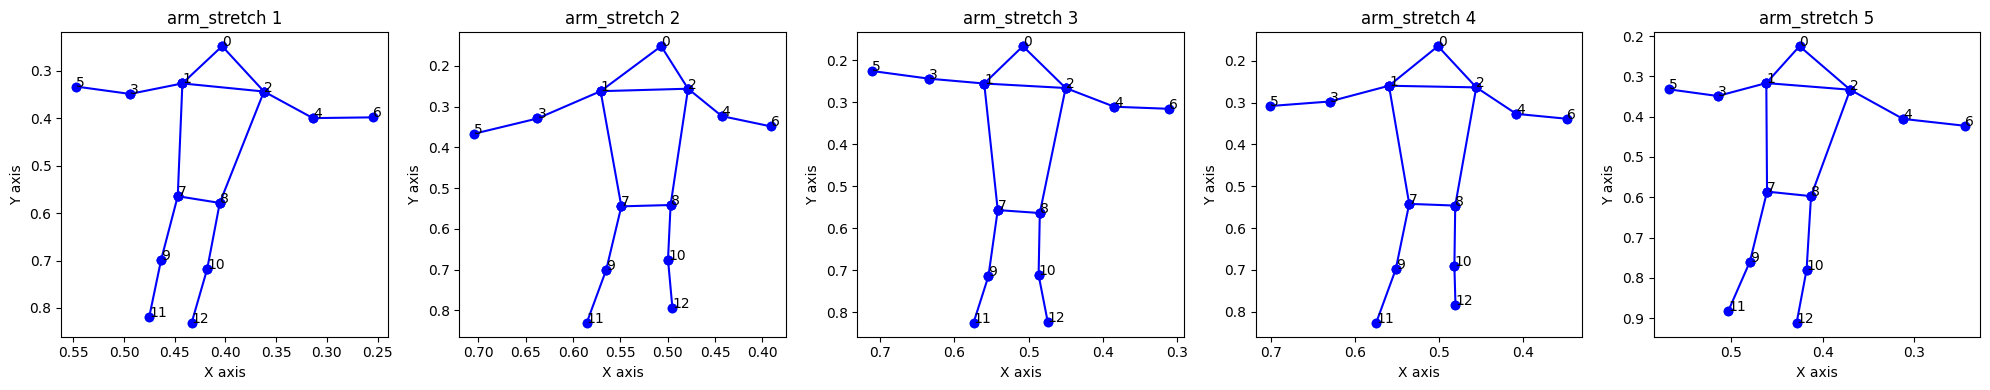

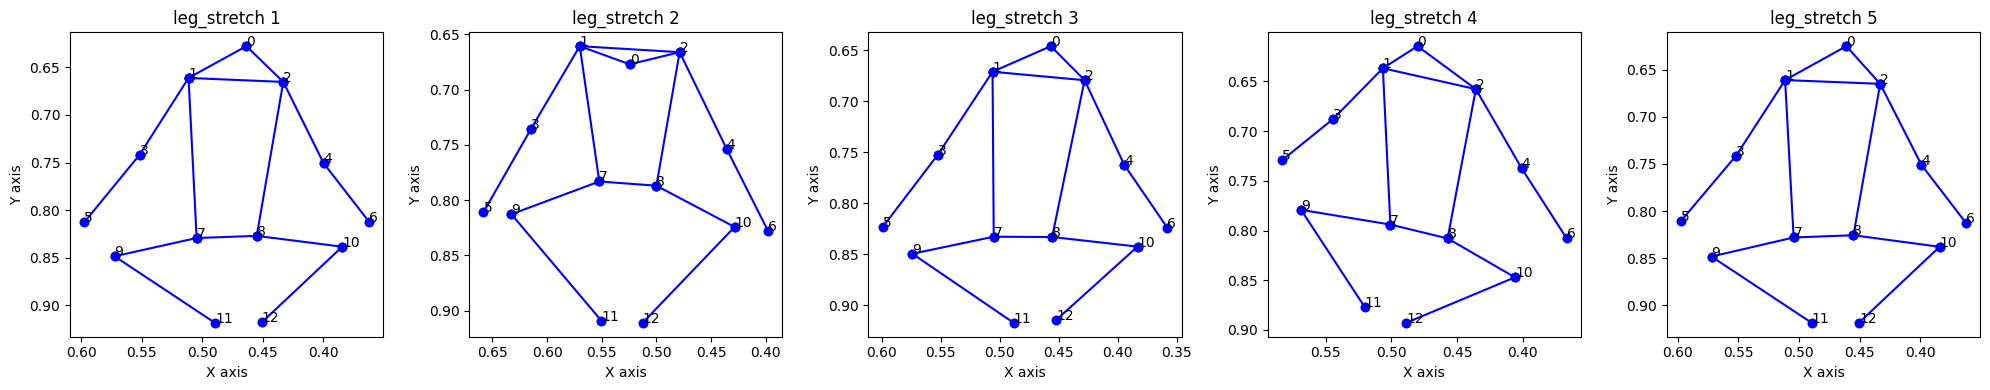

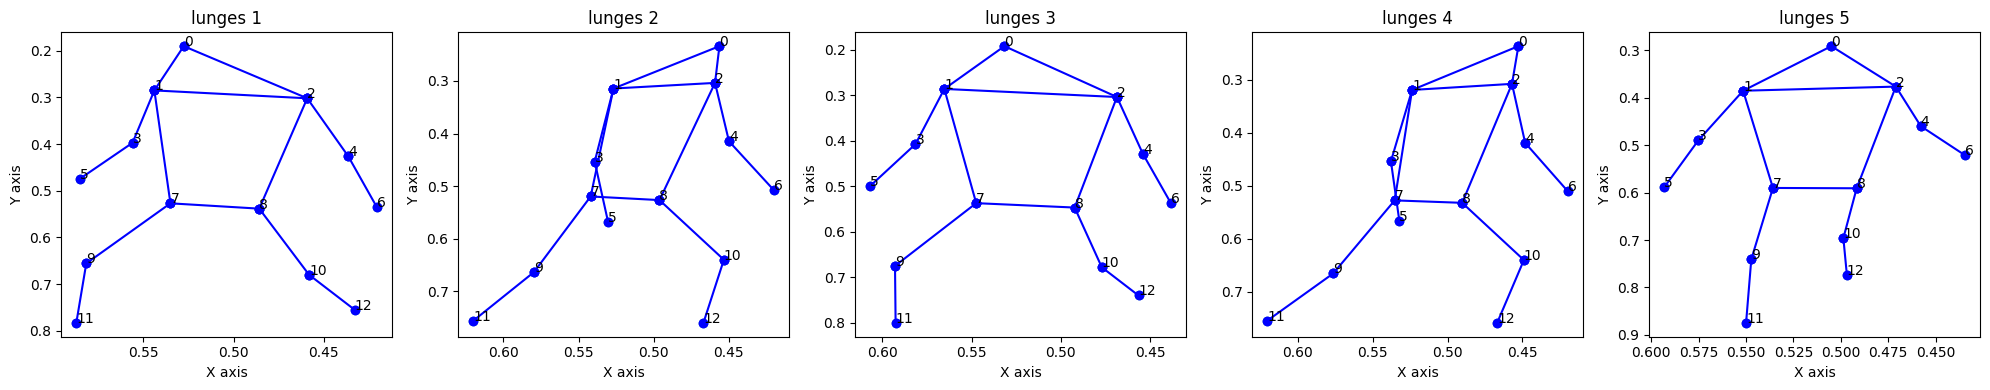

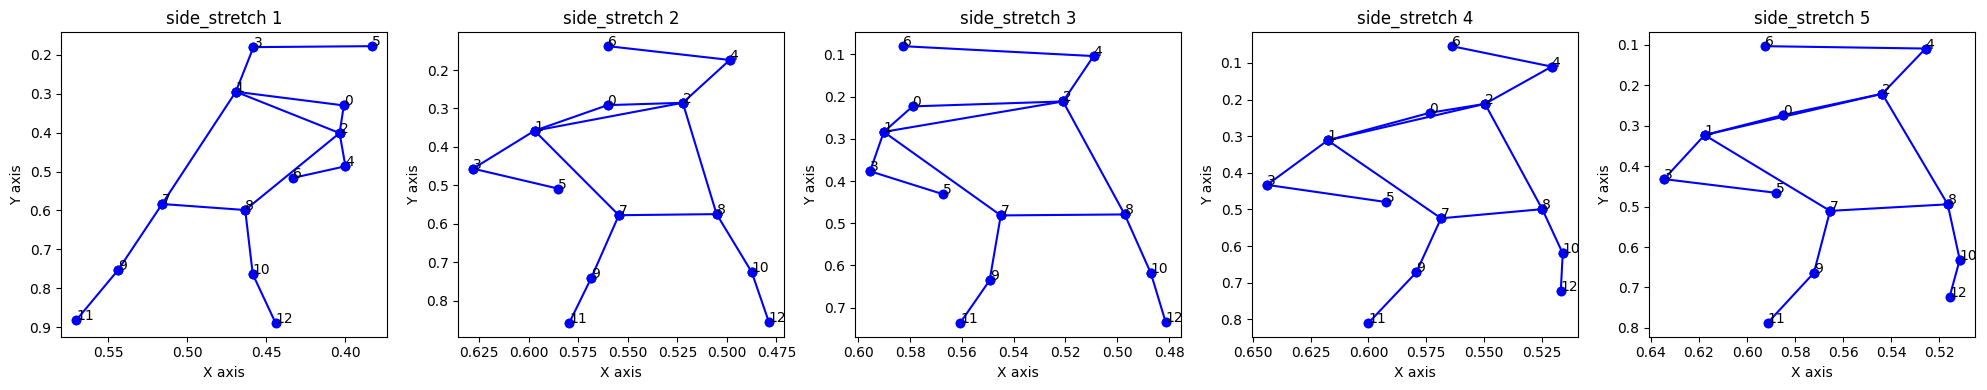

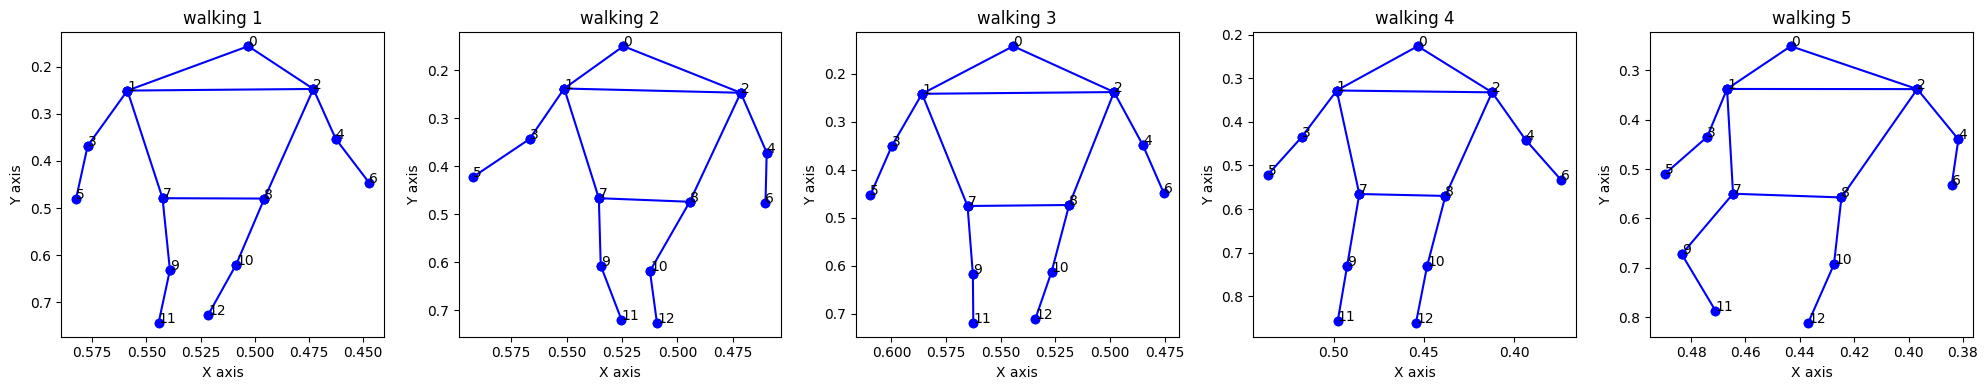

In [17]:
from utils.visualization_utils import visualize_2d_pose_actions_custom

out_poses_2d = np.load("datasets/custom/Processed v2/test_2d_poses.npy")
out_actions = np.load("datasets/custom/Processed v2/test_actions.npy")

for action in np.unique(out_actions):
    out_poses_2d_action = out_poses_2d[out_actions == action]
    visualize_2d_pose_actions_custom(out_poses_2d_action, action=action)

Let's visualise the first 2D pose and corresponding 3D poses in the custom dataset

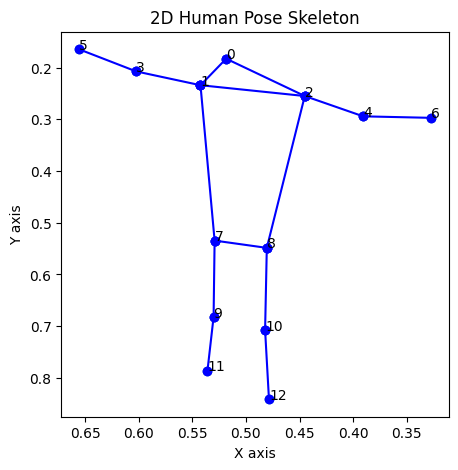

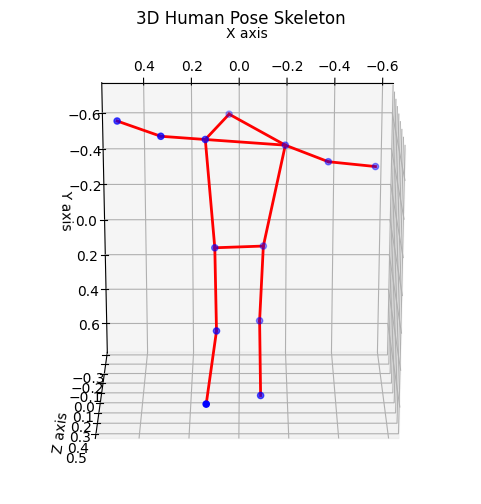

In [18]:
import numpy as np

from utils.visualization_utils import visualize_2d_pose_custom, visualize_3d_pose_custom

poses_2d = np.load("datasets/custom/Processed v2/test_2d_poses.npy")
poses_3d = np.load("datasets/custom/Processed v2/test_3d_poses.npy")

visualize_2d_pose_custom(poses_2d[0])
visualize_3d_pose_custom(poses_3d[0], elev=110, azim=90)

Let's visualise the distribution of the 5 actions in the custom train and test datasets

actions
arm_stretch     6617
leg_stretch     6483
walking         6336
lunges          6328
side_stretch    6030
Name: count, dtype: int64


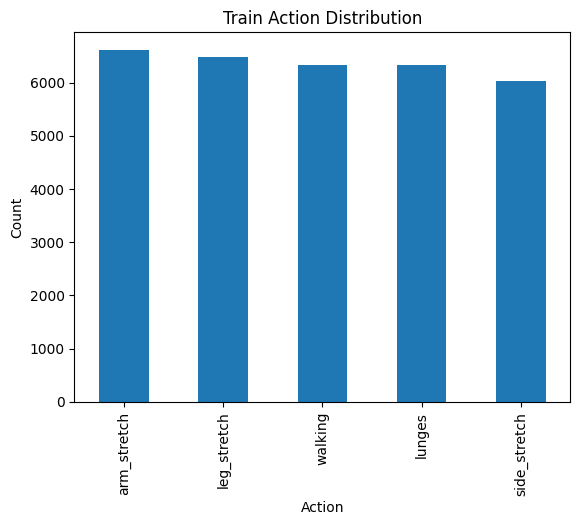

In [19]:
train_actions = np.load("datasets/custom/Processed v2/train_actions.npy")
show_action_stats(train_actions, "Train")

actions
arm_stretch     560
leg_stretch     560
lunges          560
side_stretch    560
walking         560
Name: count, dtype: int64


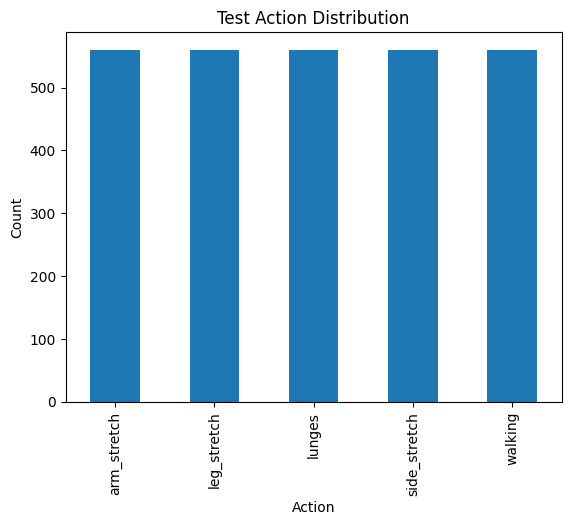

In [20]:
train_actions = np.load("datasets/custom/Processed v2/test_actions.npy")
show_action_stats(train_actions, "Test")

<h3><u>4.2 Baseline 1 - SimplePose (Simple ML model without using GNNs)</u></h2>

TODO.brian - write something meaningful here



In [21]:
from torchviz import make_dot
import torch
import os
from torchsummary import summary

def visualize_model(model, dummy_input, name, output_folder=os.path.join('visualizations')):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    summary(model, dummy_input)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
from models.simple_pose_gnn import SimplePoseGNN
from dataloader.h36m_graph_loader_with_edge_feats import Human36MGraphEdgeDataset

item = {
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
}

data = Human36MGraphEdgeDataset(
    item['training_2d_data_path'], item['training_3d_data_path'], item['training_label_path']
)

model = SimplePoseGNN(80, 5)
count_parameters(model)

251848

In [23]:
from models.simple_pose_tag import SimplePoseTAG
from dataloader.h36m_graph_loader_with_edge_feats import Human36MGraphEdgeDataset

item = {
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
}

data = Human36MGraphEdgeDataset(
    item['training_2d_data_path'], item['training_3d_data_path'], item['training_label_path']
)

model = SimplePoseTAG(80, 5)
count_parameters(model)

1019848

In [24]:
from models.simple_pose import SimplePose
from dataloader.h36M_loader import Human36MLoader

item = {
    'training_2d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'h36m', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'h36m', 'Processed', 'train_actions.npy'),
}

data = Human36MLoader(
    item['training_2d_data_path'], item['training_3d_data_path'], item['training_label_path']
)
dummy_input = torch.Tensor(data[0][0])
model = SimplePose(13, 5)
visualize_model(model, dummy_input.shape, 'SimplePose')
count_parameters(model)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [25]:
from src.simple_pose.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose', timestamp)
}
args = Namespace(**args_dict)
test_predicted_labels, test_true_labels = training_loop(args)

INFO:root:Model is currently using : cuda
INFO:root:Creating Missing Paths: model_outputs/simple_pose/2024-11-19--00-36-21
INFO:root:Saving config
INFO:root:Setup Training and Testing Dataloaders
INFO:root:Setup SimplePose model with Kaiming Weights
INFO:root:SimplePose(
  (input_linear_2d): Linear(in_features=26, out_features=1024, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x Sequential(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.6, inplace=False)
      (4): Linear(in_features=1024, out_features=1024, bias=True)
      (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.6, inplace=False)
    )
  )
  (output_3d_pose_linear): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affi

Training args are: Namespace(action_loss_multiplier=0.005, batch_size=256, learning_rate=3e-05, num_epochs=30, pose_loss_multiplier=0.995, save_path='model_outputs/simple_pose/2024-11-19--00-36-21', testing_2d_data_path='datasets/custom/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/custom/Processed/test_3d_poses.npy', testing_label_path='datasets/custom/Processed/test_actions.npy', training_2d_data_path='datasets/custom/Processed/train_2d_poses.npy', training_3d_data_path='datasets/custom/Processed/train_3d_poses.npy', training_label_path='datasets/custom/Processed/train_actions.npy')


INFO:root:Setup Optimizer
INFO:root:Setup Scheduler
INFO:root:Setup loss functions
INFO:root:Start Training and Testing Loops


Starting EPOCH: 1 / 30


Training =>: 100%|██████████| 126/126 [00:02<00:00, 56.19it/s]


Saving at epoch 0
Epoch: 0 | Total Training Loss: 1.5589003562927246 | Pose Training Loss: 1.5592951774597168 | Action Training Loss: 1.480468988418579 | Action Train Label Accuracy: 37.77411940113065


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 152.01it/s]
INFO:root:Saving model current state


Epoch: 0 | Total Testing Loss: 0.10945338010787964 | Pose Testing Loss: 0.09731125086545944 | Action Testing Loss: 2.525738000869751 | Action Test Label Accuracy: 20.0
Starting EPOCH: 2 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 63.63it/s]


Saving at epoch 1
Epoch: 1 | Total Training Loss: 0.8630828261375427 | Pose Training Loss: 0.8623040914535522 | Action Training Loss: 1.0180104970932007 | Action Train Label Accuracy: 52.81418897931292


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 130.41it/s]
INFO:root:Saving model current state


Epoch: 1 | Total Testing Loss: 0.10743128508329391 | Pose Testing Loss: 0.09399183839559555 | Action Testing Loss: 2.781881809234619 | Action Test Label Accuracy: 20.0
Starting EPOCH: 3 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 66.37it/s]


Saving at epoch 2
Epoch: 2 | Total Training Loss: 0.5140549540519714 | Pose Training Loss: 0.5123865008354187 | Action Training Loss: 0.8461111187934875 | Action Train Label Accuracy: 60.6262036404299


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 140.28it/s]
INFO:root:Saving model current state


Epoch: 2 | Total Testing Loss: 0.07805926352739334 | Pose Testing Loss: 0.06574846804141998 | Action Testing Loss: 2.52790904045105 | Action Test Label Accuracy: 20.0
Starting EPOCH: 4 / 30


Training =>: 100%|██████████| 126/126 [00:02<00:00, 62.61it/s]


Saving at epoch 3
Epoch: 3 | Total Training Loss: 0.32022804021835327 | Pose Training Loss: 0.3178306519985199 | Action Training Loss: 0.7973039746284485 | Action Train Label Accuracy: 63.94980431136237


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 116.58it/s]
INFO:root:Saving model current state


Epoch: 3 | Total Testing Loss: 0.06753110140562057 | Pose Testing Loss: 0.05662474036216736 | Action Testing Loss: 2.2378957271575928 | Action Test Label Accuracy: 20.0
Starting EPOCH: 5 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 66.11it/s]


Saving at epoch 4
Epoch: 4 | Total Training Loss: 0.2275007665157318 | Pose Training Loss: 0.22470352053642273 | Action Training Loss: 0.7841604948043823 | Action Train Label Accuracy: 65.04938808473628


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 93.95it/s]
INFO:root:Saving model current state


Epoch: 4 | Total Testing Loss: 0.0651630088686943 | Pose Testing Loss: 0.054303355515003204 | Action Testing Loss: 2.2262332439422607 | Action Test Label Accuracy: 20.0
Starting EPOCH: 6 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 66.68it/s]


Saving at epoch 5
Epoch: 5 | Total Training Loss: 0.17701999843120575 | Pose Training Loss: 0.17404508590698242 | Action Training Loss: 0.7690126895904541 | Action Train Label Accuracy: 66.04336211716469


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 110.32it/s]
INFO:root:Saving model current state


Epoch: 5 | Total Testing Loss: 0.061052221804857254 | Pose Testing Loss: 0.05053608492016792 | Action Testing Loss: 2.1537623405456543 | Action Test Label Accuracy: 21.125
Starting EPOCH: 7 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 82.89it/s]


Saving at epoch 6
Epoch: 6 | Total Training Loss: 0.14586319029331207 | Pose Training Loss: 0.142862930893898 | Action Training Loss: 0.7429213523864746 | Action Train Label Accuracy: 67.84494005094118


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 184.17it/s]
INFO:root:Saving model current state


Epoch: 6 | Total Testing Loss: 0.05832526832818985 | Pose Testing Loss: 0.048610296100378036 | Action Testing Loss: 1.9916032552719116 | Action Test Label Accuracy: 24.833333333333332
Starting EPOCH: 8 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 90.70it/s]


Saving at epoch 7
Epoch: 7 | Total Training Loss: 0.12482751905918121 | Pose Training Loss: 0.1218351274728775 | Action Training Loss: 0.7203113436698914 | Action Train Label Accuracy: 69.12468161769274


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 150.31it/s]
INFO:root:Saving model current state


Epoch: 7 | Total Testing Loss: 0.05531355366110802 | Pose Testing Loss: 0.04583393409848213 | Action Testing Loss: 1.9417572021484375 | Action Test Label Accuracy: 27.541666666666664
Starting EPOCH: 9 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 68.00it/s]


Saving at epoch 8
Epoch: 8 | Total Training Loss: 0.10941793769598007 | Pose Training Loss: 0.10649412125349045 | Action Training Loss: 0.6912586688995361 | Action Train Label Accuracy: 70.97595825309064


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 82.14it/s]
INFO:root:Saving model current state


Epoch: 8 | Total Testing Loss: 0.05298752710223198 | Pose Testing Loss: 0.0440925657749176 | Action Testing Loss: 1.8230844736099243 | Action Test Label Accuracy: 34.08333333333333
Starting EPOCH: 10 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 65.73it/s]


Saving at epoch 9
Epoch: 9 | Total Training Loss: 0.09746431559324265 | Pose Training Loss: 0.09466439485549927 | Action Training Loss: 0.6546502113342285 | Action Train Label Accuracy: 72.79306703112381


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 163.10it/s]
INFO:root:Saving model current state


Epoch: 9 | Total Testing Loss: 0.050760041922330856 | Pose Testing Loss: 0.041776809841394424 | Action Testing Loss: 1.838424563407898 | Action Test Label Accuracy: 33.916666666666664
Starting EPOCH: 11 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 65.72it/s]


Saving at epoch 10
Epoch: 10 | Total Training Loss: 0.0882495567202568 | Pose Training Loss: 0.08558233827352524 | Action Training Loss: 0.6190286874771118 | Action Train Label Accuracy: 74.68161769273777


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 122.67it/s]
INFO:root:Saving model current state


Epoch: 10 | Total Testing Loss: 0.04857379570603371 | Pose Testing Loss: 0.040452878922224045 | Action Testing Loss: 1.664636254310608 | Action Test Label Accuracy: 40.25
Starting EPOCH: 12 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 76.80it/s]


Saving at epoch 11
Epoch: 11 | Total Training Loss: 0.08113653212785721 | Pose Training Loss: 0.07857946306467056 | Action Training Loss: 0.5899898409843445 | Action Train Label Accuracy: 76.01105796111077


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 139.31it/s]
INFO:root:Saving model current state


Epoch: 11 | Total Testing Loss: 0.046578627079725266 | Pose Testing Loss: 0.038771629333496094 | Action Testing Loss: 1.6001710891723633 | Action Test Label Accuracy: 42.083333333333336
Starting EPOCH: 13 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 94.45it/s]


Saving at epoch 12
Epoch: 12 | Total Training Loss: 0.07469599694013596 | Pose Training Loss: 0.07225435972213745 | Action Training Loss: 0.5605771541595459 | Action Train Label Accuracy: 77.36534758029447


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 180.04it/s]
INFO:root:Saving model current state


Epoch: 12 | Total Testing Loss: 0.043864842504262924 | Pose Testing Loss: 0.036318518221378326 | Action Testing Loss: 1.5455825328826904 | Action Test Label Accuracy: 43.666666666666664
Starting EPOCH: 14 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 93.82it/s]


Saving at epoch 13
Epoch: 13 | Total Training Loss: 0.06891099363565445 | Pose Training Loss: 0.06659168750047684 | Action Training Loss: 0.5304578542709351 | Action Train Label Accuracy: 78.92775051251786


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 177.40it/s]
INFO:root:Saving model current state


Epoch: 13 | Total Testing Loss: 0.04218587651848793 | Pose Testing Loss: 0.03487175330519676 | Action Testing Loss: 1.497696042060852 | Action Test Label Accuracy: 44.625
Starting EPOCH: 15 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 95.54it/s]


Saving at epoch 14
Epoch: 14 | Total Training Loss: 0.06466474384069443 | Pose Training Loss: 0.0624564066529274 | Action Training Loss: 0.5041261911392212 | Action Train Label Accuracy: 79.8844505187302


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 181.48it/s]
INFO:root:Saving model current state


Epoch: 14 | Total Testing Loss: 0.04054662212729454 | Pose Testing Loss: 0.033579982817173004 | Action Testing Loss: 1.4269077777862549 | Action Test Label Accuracy: 45.958333333333336
Starting EPOCH: 16 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 94.51it/s]


Saving at epoch 15
Epoch: 15 | Total Training Loss: 0.06061115488409996 | Pose Training Loss: 0.058498285710811615 | Action Training Loss: 0.4810710549354553 | Action Train Label Accuracy: 80.88774305771261


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 150.16it/s]
INFO:root:Saving model current state


Epoch: 15 | Total Testing Loss: 0.03951456770300865 | Pose Testing Loss: 0.03281419724225998 | Action Testing Loss: 1.3728889226913452 | Action Test Label Accuracy: 51.66666666666667
Starting EPOCH: 17 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 92.27it/s]


Saving at epoch 16
Epoch: 16 | Total Training Loss: 0.05715899169445038 | Pose Training Loss: 0.055137936025857925 | Action Training Loss: 0.45935145020484924 | Action Train Label Accuracy: 81.62079890662856


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 178.17it/s]
INFO:root:Saving model current state


Epoch: 16 | Total Testing Loss: 0.03826860338449478 | Pose Testing Loss: 0.031938232481479645 | Action Testing Loss: 1.2980114221572876 | Action Test Label Accuracy: 49.791666666666664
Starting EPOCH: 18 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 93.07it/s]


Saving at epoch 17
Epoch: 17 | Total Training Loss: 0.05385797843337059 | Pose Training Loss: 0.05192126706242561 | Action Training Loss: 0.43926724791526794 | Action Train Label Accuracy: 82.57128657513823


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 170.08it/s]
INFO:root:Saving model current state


Epoch: 17 | Total Testing Loss: 0.03640725836157799 | Pose Testing Loss: 0.030063597485423088 | Action Testing Loss: 1.298796534538269 | Action Test Label Accuracy: 47.125
Starting EPOCH: 19 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 92.08it/s]


Saving at epoch 18
Epoch: 18 | Total Training Loss: 0.05071563273668289 | Pose Training Loss: 0.048878688365221024 | Action Training Loss: 0.4162691831588745 | Action Train Label Accuracy: 83.72056905013356


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 153.97it/s]
INFO:root:Saving model current state


Epoch: 18 | Total Testing Loss: 0.03553896024823189 | Pose Testing Loss: 0.0284161064773798 | Action Testing Loss: 1.4529874324798584 | Action Test Label Accuracy: 45.25
Starting EPOCH: 20 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 92.03it/s]


Saving at epoch 19
Epoch: 19 | Total Training Loss: 0.04824809357523918 | Pose Training Loss: 0.04646093770861626 | Action Training Loss: 0.40389397740364075 | Action Train Label Accuracy: 84.27967944337455


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 171.00it/s]
INFO:root:Saving model current state


Epoch: 19 | Total Testing Loss: 0.034139517694711685 | Pose Testing Loss: 0.027494562789797783 | Action Testing Loss: 1.3564854860305786 | Action Test Label Accuracy: 52.916666666666664
Starting EPOCH: 21 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 96.46it/s]


Saving at epoch 20
Epoch: 20 | Total Training Loss: 0.0459897518157959 | Pose Training Loss: 0.044285498559474945 | Action Training Loss: 0.3851347267627716 | Action Train Label Accuracy: 84.81704665465615


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 162.99it/s]
INFO:root:Saving model current state


Epoch: 20 | Total Testing Loss: 0.03275473788380623 | Pose Testing Loss: 0.026304978877305984 | Action Testing Loss: 1.3162574768066406 | Action Test Label Accuracy: 52.37500000000001
Starting EPOCH: 22 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 90.86it/s]


Saving at epoch 21
Epoch: 21 | Total Training Loss: 0.04383626580238342 | Pose Training Loss: 0.042204950004816055 | Action Training Loss: 0.36846598982810974 | Action Train Label Accuracy: 85.50040380195068


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 167.02it/s]
INFO:root:Saving model current state


Epoch: 21 | Total Testing Loss: 0.0314013846218586 | Pose Testing Loss: 0.025875627994537354 | Action Testing Loss: 1.1310266256332397 | Action Test Label Accuracy: 56.125
Starting EPOCH: 23 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 92.10it/s]


Saving at epoch 22
Epoch: 22 | Total Training Loss: 0.04194558411836624 | Pose Training Loss: 0.040367741137742996 | Action Training Loss: 0.3559325337409973 | Action Train Label Accuracy: 86.07193887059701


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 159.03it/s]
INFO:root:Saving model current state


Epoch: 22 | Total Testing Loss: 0.03070901706814766 | Pose Testing Loss: 0.02532772719860077 | Action Testing Loss: 1.1015857458114624 | Action Test Label Accuracy: 56.208333333333336
Starting EPOCH: 24 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 94.96it/s]


Saving at epoch 23
Epoch: 23 | Total Training Loss: 0.040214914828538895 | Pose Training Loss: 0.038678642362356186 | Action Training Loss: 0.3459315001964569 | Action Train Label Accuracy: 86.57513822451388


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 179.85it/s]
INFO:root:Saving model current state


Epoch: 23 | Total Testing Loss: 0.03052624501287937 | Pose Testing Loss: 0.02446441352367401 | Action Testing Loss: 1.2368309497833252 | Action Test Label Accuracy: 53.708333333333336
Starting EPOCH: 25 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 64.19it/s]


Saving at epoch 24
Epoch: 24 | Total Training Loss: 0.03873751685023308 | Pose Training Loss: 0.03727412223815918 | Action Training Loss: 0.3299536108970642 | Action Train Label Accuracy: 87.43244082748338


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 110.59it/s]
INFO:root:Saving model current state


Epoch: 24 | Total Testing Loss: 0.02842859923839569 | Pose Testing Loss: 0.024027395993471146 | Action Testing Loss: 0.9042686820030212 | Action Test Label Accuracy: 58.04166666666667
Starting EPOCH: 26 / 30


Training =>: 100%|██████████| 126/126 [00:02<00:00, 60.95it/s]


Saving at epoch 25
Epoch: 25 | Total Training Loss: 0.03734728693962097 | Pose Training Loss: 0.03593524917960167 | Action Training Loss: 0.3183442950248718 | Action Train Label Accuracy: 87.86109212896814


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 128.49it/s]
INFO:root:Saving model current state


Epoch: 25 | Total Testing Loss: 0.029217317700386047 | Pose Testing Loss: 0.023438146337866783 | Action Testing Loss: 1.1792727708816528 | Action Test Label Accuracy: 53.5
Starting EPOCH: 27 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 63.46it/s]


Saving at epoch 26
Epoch: 26 | Total Training Loss: 0.03597152978181839 | Pose Training Loss: 0.034612808376550674 | Action Training Loss: 0.306358277797699 | Action Train Label Accuracy: 88.42330869106044


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 117.59it/s]
INFO:root:Saving model current state


Epoch: 26 | Total Testing Loss: 0.028722798451781273 | Pose Testing Loss: 0.023099645972251892 | Action Testing Loss: 1.1477301120758057 | Action Test Label Accuracy: 54.125
Starting EPOCH: 28 / 30


Training =>: 100%|██████████| 126/126 [00:02<00:00, 60.50it/s]


Saving at epoch 27
Epoch: 27 | Total Training Loss: 0.03502396494150162 | Pose Training Loss: 0.033701684325933456 | Action Training Loss: 0.2981579303741455 | Action Train Label Accuracy: 88.89234018761259


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 74.18it/s]
INFO:root:Saving model current state


Epoch: 27 | Total Testing Loss: 0.028156457468867302 | Pose Testing Loss: 0.02299412712454796 | Action Testing Loss: 1.0554603338241577 | Action Test Label Accuracy: 55.25
Starting EPOCH: 29 / 30


Training =>: 100%|██████████| 126/126 [00:01<00:00, 63.45it/s]


Saving at epoch 28
Epoch: 28 | Total Training Loss: 0.03403252735733986 | Pose Training Loss: 0.03274085372686386 | Action Training Loss: 0.29107755422592163 | Action Train Label Accuracy: 88.8208983040318


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 140.09it/s]
INFO:root:Saving model current state


Epoch: 28 | Total Testing Loss: 0.02797355130314827 | Pose Testing Loss: 0.022793572396039963 | Action Testing Loss: 1.0587886571884155 | Action Test Label Accuracy: 55.208333333333336
Starting EPOCH: 30 / 30


Training =>: 100%|██████████| 126/126 [00:02<00:00, 61.74it/s]


Saving at epoch 29
Epoch: 29 | Total Training Loss: 0.03303007036447525 | Pose Training Loss: 0.03179652988910675 | Action Training Loss: 0.27850469946861267 | Action Train Label Accuracy: 89.47008759396161


Testing =>: 100%|██████████| 10/10 [00:00<00:00, 112.73it/s]
INFO:root:Saving model current state


Epoch: 29 | Total Testing Loss: 0.027670342475175858 | Pose Testing Loss: 0.022430237382650375 | Action Testing Loss: 1.0704518556594849 | Action Test Label Accuracy: 55.541666666666664


<Figure size 640x480 with 0 Axes>

Confusion Matrix Without Normalization


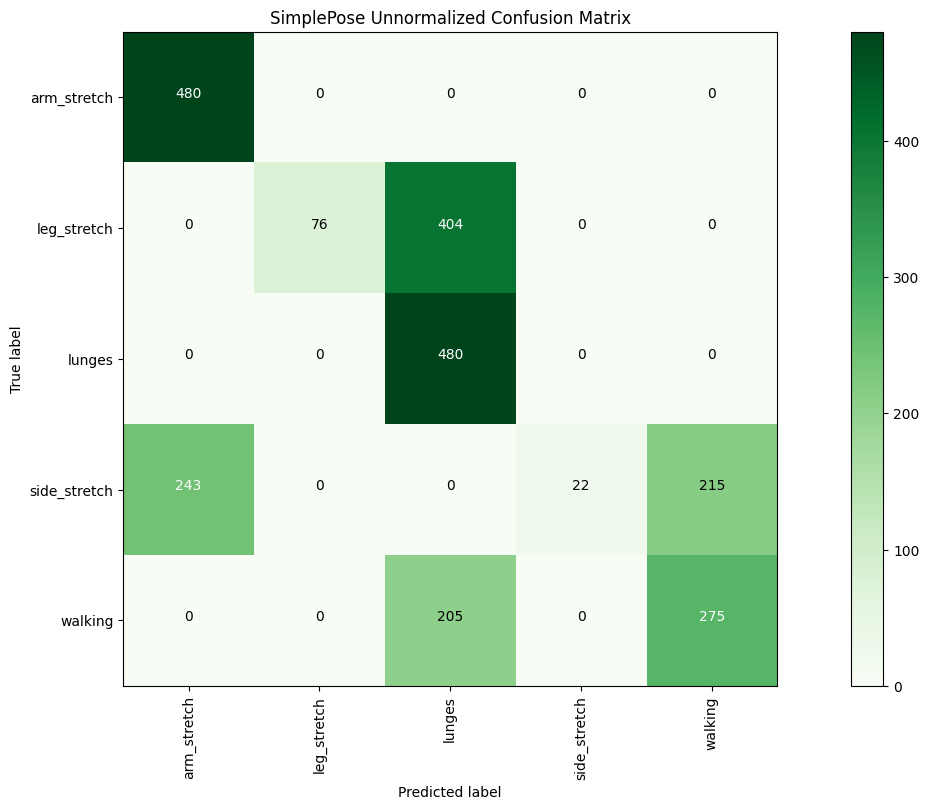

Normalized Confusion Matrix


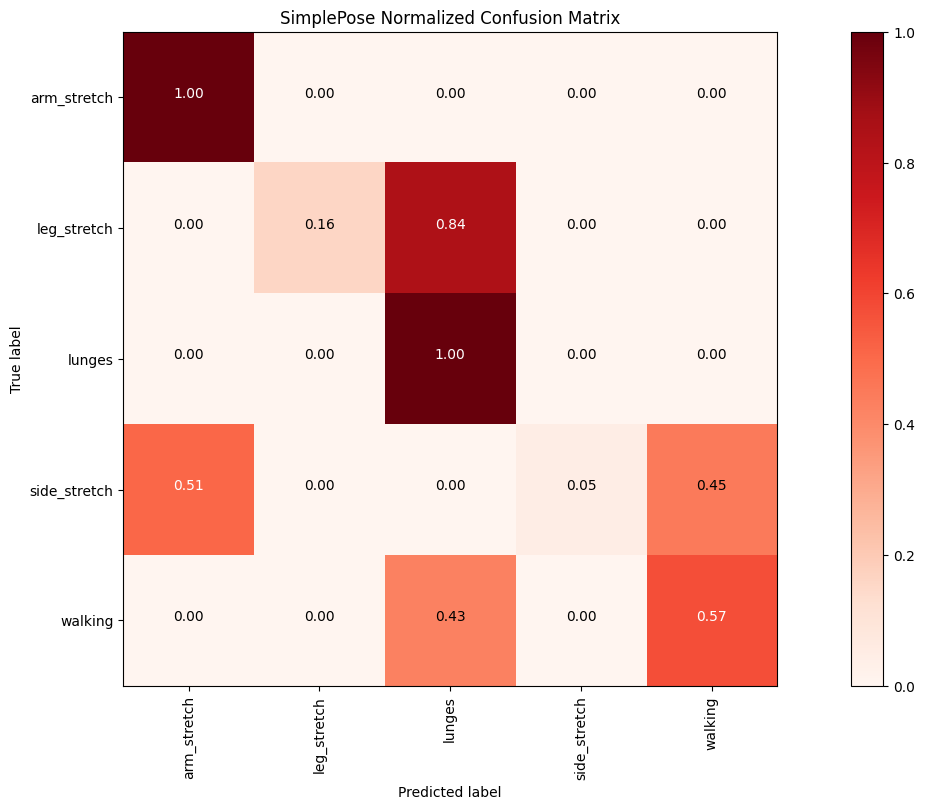

In [26]:
from sklearn.metrics import confusion_matrix
from utils.visualization_utils import plot_confusion_matrix

classes = ["arm_stretch", "leg_stretch", "lunges", "side_stretch", "walking"]

cm = confusion_matrix(test_true_labels, test_predicted_labels)
plot_confusion_matrix(cm, classes=classes, normalize=False, title="SimplePose Unnormalized Confusion Matrix")
plot_confusion_matrix(cm, classes=classes, normalize=True, title="SimplePose Normalized Confusion Matrix")

<h2><u>5. Baseline 2 - SimplePoseGNN (Simple ML model using GNNs)</u></h2>

TODO.brian to write something meaningful here

In [28]:
from src.simple_pose_gnn.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 3e-5,
    'num_epochs': 30,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gnn', timestamp)
}
args = Namespace(**args_dict)
test_predicted_labels, test_true_labels = training_loop(args)

INFO:root:Model is currently using : cuda
INFO:root:Creating Missing Paths: model_outputs/simple_pose_gnn/2024-11-19--00-38-15
INFO:root:Saving config
INFO:root:Setup Training and Testing Dataloaders
INFO:root:Setup SimplePoseGNN model
INFO:root:SimplePoseGNN(
  (input_layer): Linear(in_features=2, out_features=80, bias=True)
  (pos_linear): Linear(in_features=5, out_features=80, bias=True)
  (edge_linear): Linear(in_features=4, out_features=80, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x Sequential(
      (0): GraphConvModule(
        (conv_1): GraphConv(in=80, out=80, normalization=both, activation=None)
        (batch_norm_1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_2): GraphConv(in=80, out=80, normalization=both, activation=None)
        (batch_norm_2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (feed_forward_1): Linear(in_features=80, out_features=80, bias=True)
        (dropou

Training args are: Namespace(action_loss_multiplier=0.005, batch_size=256, learning_rate=3e-05, num_epochs=30, pose_loss_multiplier=0.995, save_path='model_outputs/simple_pose_gnn/2024-11-19--00-38-15', testing_2d_data_path='datasets/custom/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/custom/Processed/test_3d_poses.npy', testing_label_path='datasets/custom/Processed/test_actions.npy', training_2d_data_path='datasets/custom/Processed/train_2d_poses.npy', training_3d_data_path='datasets/custom/Processed/train_3d_poses.npy', training_label_path='datasets/custom/Processed/train_actions.npy')
Starting EPOCH: 1 / 30


DGLError: [00:38:16] /opt/dgl/src/runtime/c_runtime_api.cc:82: Check failed: allow_missing: Device API cuda is not enabled. Please install the cuda version of dgl.
Stack trace:
  [bt] (0) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x4f) [0x77664f31535f]
  [bt] (1) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::DeviceAPIManager::GetAPI(std::string, bool)+0x37c) [0x77664f5cbedc]
  [bt] (2) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::DeviceAPI::Get(DGLContext, bool)+0x1e3) [0x77664f5c64b3]
  [bt] (3) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::NDArray::Empty(std::vector<long, std::allocator<long> >, DGLDataType, DGLContext)+0x15b) [0x77664f5e8a4b]
  [bt] (4) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::NDArray::CopyTo(DGLContext const&) const+0xc0) [0x77664f625ad0]
  [bt] (5) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::aten::COOMatrix::CopyTo(DGLContext const&) const+0x7d) [0x77664f749ccd]
  [bt] (6) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::UnitGraph::CopyTo(std::shared_ptr<dgl::BaseHeteroGraph>, DGLContext const&)+0x2aa) [0x77664f73907a]
  [bt] (7) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::HeteroGraph::CopyTo(std::shared_ptr<dgl::BaseHeteroGraph>, DGLContext const&)+0xf5) [0x77664f637c75]
  [bt] (8) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(+0x446b8b) [0x77664f646b8b]



In [ ]:
from sklearn.metrics import confusion_matrix
from utils.visualization_utils import plot_confusion_matrix

classes = ["arm_stretch", "leg_stretch", "lunges", "side_stretch", "walking"]

cm = confusion_matrix(test_true_labels, test_predicted_labels)
plot_confusion_matrix(cm, classes=classes, normalize=False, title="SimplePoseGNN Unnormalized Confusion Matrix")
plot_confusion_matrix(cm, classes=classes, normalize=True, title="SimplePoseGNN Normalized Confusion Matrix")

<h2><u>6. Improvement 1 - SimplePoseGAT</u></h2>

TODO.parash to write something meaningful here


In [29]:
from src.simple_pose_gat.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 1e-4,
    'num_epochs': 20,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gat', timestamp)
}
args = Namespace(**args_dict)
test_predicted_labels, test_true_labels = training_loop(args)

ImportError: Cannot load DGL C++ sparse library

In [ ]:
from sklearn.metrics import confusion_matrix
from utils.visualization_utils import plot_confusion_matrix

classes = ["arm_stretch", "leg_stretch", "lunges", "side_stretch", "walking"]

cm = confusion_matrix(test_true_labels, test_predicted_labels)
plot_confusion_matrix(cm, classes=classes, normalize=False, title="SimplePoseGAT Unnormalized Confusion Matrix")
plot_confusion_matrix(cm, classes=classes, normalize=True, title="SimplePoseGAT Normalized Confusion Matrix")

<h2><u>7. Improvement 2 - SimplePoseTAG model</u></h2>

TODO.all

In [30]:
from src.simple_pose_tag.train_and_test import training_loop
from argparse import Namespace
import os
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d--%H-%M-%S")

args_dict = {
    'learning_rate': 1e-4,
    'num_epochs': 20,
    'batch_size': 256,
    'action_loss_multiplier': 0.005,
    'pose_loss_multiplier': 0.995,
    'training_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_2d_poses.npy'),
    'training_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'train_3d_poses.npy'),
    'training_label_path': os.path.join('datasets', 'custom', 'Processed', 'train_actions.npy'),
    'testing_2d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_2d_poses.npy'),
    'testing_3d_data_path': os.path.join('datasets', 'custom', 'Processed', 'test_3d_poses.npy'),
    'testing_label_path': os.path.join('datasets', 'custom', 'Processed', 'test_actions.npy'),
    'save_path': os.path.join('model_outputs', 'simple_pose_gat', timestamp)
}
args = Namespace(**args_dict)
test_predicted_labels, test_true_labels = training_loop(args)

INFO:root:Model is currently using : cuda
INFO:root:Creating Missing Paths: model_outputs/simple_pose_gat/2024-11-19--00-40-06
INFO:root:Saving config
INFO:root:Setup Training and Testing Dataloaders
INFO:root:Setup SimplePoseTAG model
INFO:root:SimplePoseTAG(
  (input_layer): Linear(in_features=2, out_features=80, bias=True)
  (pos_linear): Linear(in_features=5, out_features=80, bias=True)
  (edge_linear): Linear(in_features=4, out_features=80, bias=True)
  (blocks): ModuleList(
    (0-5): 6 x Sequential(
      (0): TAGConvModule(
        (conv_1): TAGConv(
          (lin): Linear(in_features=480, out_features=80, bias=True)
        )
        (batch_norm_1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_2): TAGConv(
          (lin): Linear(in_features=480, out_features=80, bias=True)
        )
        (batch_norm_2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (feed_forward_1): Linear(in_featur

Training args are: Namespace(action_loss_multiplier=0.005, batch_size=256, learning_rate=0.0001, num_epochs=20, pose_loss_multiplier=0.995, save_path='model_outputs/simple_pose_gat/2024-11-19--00-40-06', testing_2d_data_path='datasets/custom/Processed/test_2d_poses.npy', testing_3d_data_path='datasets/custom/Processed/test_3d_poses.npy', testing_label_path='datasets/custom/Processed/test_actions.npy', training_2d_data_path='datasets/custom/Processed/train_2d_poses.npy', training_3d_data_path='datasets/custom/Processed/train_3d_poses.npy', training_label_path='datasets/custom/Processed/train_actions.npy')
Starting EPOCH: 1 / 20


DGLError: [00:40:07] /opt/dgl/src/runtime/c_runtime_api.cc:82: Check failed: allow_missing: Device API cuda is not enabled. Please install the cuda version of dgl.
Stack trace:
  [bt] (0) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x4f) [0x77664f31535f]
  [bt] (1) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::DeviceAPIManager::GetAPI(std::string, bool)+0x37c) [0x77664f5cbedc]
  [bt] (2) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::DeviceAPI::Get(DGLContext, bool)+0x1e3) [0x77664f5c64b3]
  [bt] (3) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::NDArray::Empty(std::vector<long, std::allocator<long> >, DGLDataType, DGLContext)+0x15b) [0x77664f5e8a4b]
  [bt] (4) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::runtime::NDArray::CopyTo(DGLContext const&) const+0xc0) [0x77664f625ad0]
  [bt] (5) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::aten::COOMatrix::CopyTo(DGLContext const&) const+0x7d) [0x77664f749ccd]
  [bt] (6) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::UnitGraph::CopyTo(std::shared_ptr<dgl::BaseHeteroGraph>, DGLContext const&)+0x2aa) [0x77664f73907a]
  [bt] (7) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(dgl::HeteroGraph::CopyTo(std::shared_ptr<dgl::BaseHeteroGraph>, DGLContext const&)+0xf5) [0x77664f637c75]
  [bt] (8) /home/nwjbrandon/anaconda3/envs/CS5284/lib/python3.8/site-packages/dgl/libdgl.so(+0x446b8b) [0x77664f646b8b]



In [ ]:
from sklearn.metrics import confusion_matrix
from utils.visualization_utils import plot_confusion_matrix

classes = ["arm_stretch", "leg_stretch", "lunges", "side_stretch", "walking"]

cm = confusion_matrix(test_true_labels, test_predicted_labels)
plot_confusion_matrix(cm, classes=classes, normalize=False, title="SimplePoseTAG Unnormalized Confusion Matrix")
plot_confusion_matrix(cm, classes=classes, normalize=True, title="SimplePoseTAG Normalized Confusion Matrix")

<h2><u>5. Evaluation<u></h2>

<h3><u>5.1 Human 3.6M Dataset<u></h3>

In [ ]:
# Save the Figures
from utils.visualization_utils import save_fig
save_files = {
    'SimplePose': os.path.join('final_weights', 'custom', 'simple_pose_custom.pth'),
    'SimplePoseGNN': os.path.join('final_weights', 'custom', "simple_pose_gnn_custom.pth"),
    'SimplePoseGAT': os.path.join('final_weights', 'custom', "simple_pose_gat_custom.pth"), 
    'SimplePoseTAG': os.path.join('final_weights', 'custom', "simple_pose_tag_custom.pth"),
}

save_fig(save_files, 'custom',  os.path.join('visualizations', 'custom'))

save_files = {
    'SimplePose': os.path.join('final_weights', 'h36m', 'simple_pose_h36m.pth'),
    'SimplePoseGNN': os.path.join('final_weights', 'h36m', "simple_pose_gnn_h36m.pth"),
    'SimplePoseGAT': os.path.join('final_weights', 'h36m', "simple_pose_gat_h36m.pth"), 
    'SimplePoseTAG': os.path.join('final_weights', 'h36m', "simple_pose_tag_h36m.pth"),
}

save_fig(save_files, 'h36m', os.path.join('visualizations', 'h36m'))

<h2><u>6. Lessons Learnt & Conclusions </u></h2>


Talk about the history of development and optimizations we made

<h2><u>7. Resources</u></h2>


TODO add blogs, documentations , us